In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

DB_PATH = '/Users/beans/Desktop/TeamHousing/data/processed/nyc_demolitions.db'
HOUSING_PATH = '/Users/beans/Desktop/TeamHousing/data/HousingDB_post2010.csv'
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

queryowner_demo = """
SELECT *
FROM fact_demolitions f   
"""

fact_owner_demo = pd.read_sql_query(queryowner_demo, conn)

queryshelter = """
SELECT *
FROM fact_shelters
"""
fact_shelter = pd.read_sql_query(queryshelter, conn)

display(fact_owner_demo.sort_values(by=['bin'],ascending=False).head())
display(fact_shelter.sort_values(by=['report_date'],ascending=False).head())

# setting job_typeid to strings to represent what the job done is
mapdemo = {1:'construction',2:'demolition'}
fact_owner_demo['job_typeid'] = fact_owner_demo['job_typeid'].map(mapdemo)

# setting ownership_id 1 to private and 2/3 to affordable (government & nonprofit)
mapowner = {1:'private',2:'affordable',3:'affordable'}
fact_owner_demo['ownership_id'] = fact_owner_demo['ownership_id'].map(mapowner)

fact_owner_demo.count()

,month_date,bin,job_typeid,ownership_id,borough,date_filed,date_completed,time_of_completion
13032,2023-03-01 00:00:00,5869568,2,1,Staten Island,2022-11-18 00:00:00,2023-03-13 00:00:00,115
12397,2018-08-01 00:00:00,5867189,2,1,Staten Island,2018-06-21 00:00:00,2018-08-03 00:00:00,43
12395,2018-09-01 00:00:00,5867187,2,1,Staten Island,2018-06-21 00:00:00,2018-09-24 00:00:00,95
12394,2018-11-01 00:00:00,5867186,2,1,Staten Island,2018-06-21 00:00:00,2018-11-26 00:00:00,158
12393,2018-11-01 00:00:00,5867185,2,1,Staten Island,2018-06-21 00:00:00,2018-11-26 00:00:00,158


,report_date,shelter_count
106,2024-12-01 00:00:00,67298
107,2024-11-01 00:00:00,66981
108,2024-10-01 00:00:00,67218
109,2024-09-01 00:00:00,68336
110,2024-08-01 00:00:00,68549


month_date            15364
bin                   15364
job_typeid            15364
ownership_id          15364
borough               15364
date_filed            15364
date_completed        15364
time_of_completion    15364
dtype: int64

In [3]:
# table plots all constructions and demolitions by borough
# aggregation counts totals for each job type (construction or demolition) & average time_of_completion per job type
# FINDINGS: takes a lot longer for construction than demolition between private and affordable
boroughagg = fact_owner_demo.groupby(['ownership_id','job_typeid']).agg({'month_date':'count','time_of_completion':'mean'}).reset_index()

boroughagg

,ownership_id,job_typeid,month_date,time_of_completion
0,affordable,construction,694,1554.889049
1,affordable,demolition,302,161.311258
2,private,construction,10468,1579.296905
3,private,demolition,3900,228.393846


In [4]:
# im curious to know if demolition/construction is mutually exclusive (gonna use the original csv for the unique identifier)

housingcsv = pd.read_csv(HOUSING_PATH)

housingcsv = housingcsv[housingcsv['Ownership'].notna()]

housingcsv['ownership_clean'] = housingcsv['Ownership'].str.strip()

housingcsv['DateComplt'] = pd.to_datetime(housingcsv['DateComplt'])


housingcsv = housingcsv[
    (housingcsv['Job_Type'].isin(['New Building', 'Demolition'])) &
    (housingcsv['Job_Status'] == '5. Completed Construction') &
    (housingcsv['ResidFlag'] == 'Residential') &
    (housingcsv['NonresFlag'].isna()) &
    (housingcsv['DateFiled'].notna()) &
    (housingcsv['DateComplt'].notna()) &
    (housingcsv['DateComplt'].dt.year.between(2016, 2024))
]

# 3064 DUPLICATED BIN hmmm
housingcsv['BIN'].duplicated().sum()

# removing duplicates to see if changes spread of data
#housingcsv.drop_duplicates(subset=['BIN'],inplace=True)

# quick clean (from original schema file )
housingcsv['Ownership'] = housingcsv['ownership_clean'].apply(lambda x: x.split(':')[0])
housingcsv['Ownership'] = housingcsv['Ownership'].apply(lambda x: x.split(',')[0])

csvmap = {'Private For-Profit':'Not Affordable','Government':'Affordable','Private Non-Profit':'Affordable'}
housingcsv['Ownership'] = housingcsv['Ownership'].map(csvmap)
# doing same groupby as code block above, trying to visualize if spread has changed
# FINDINGS: PROPORTION HAS DEFINITELY CHANGED, AFFORDABLE PROPORTION OF DEMOLITION IS 
housingcsv.groupby(['Ownership','Job_Type']).agg({'Job_Number':'count'})


# JUSTIFYING IF WE SHOULD REMOVE DUPLICATED
housingcsv['trueflag'] = housingcsv['BIN'].duplicated()
demodup = housingcsv[(housingcsv['trueflag'] == 1)]

display(demodup['BIN'].head)


# three dups
duptestone = demodup[demodup['BIN'] == 2130391]
display(duptestone[['Boro','Ownership','Job_Type','AddressNum','AddressSt','DateFiled','DatePermit','DateComplt','BIN']])

# this one is weird
duptesttwo = demodup[demodup['BIN'] == 2094743]
display(duptesttwo[['Boro','Ownership','Job_Type','AddressNum','AddressSt','DateFiled','DatePermit','DateComplt','BIN']])

# test 3 has different dates in completed, strange
duptesthree = demodup[demodup['BIN'] == 1046469]
display(duptesthree[['Boro','Ownership','Job_Type','AddressNum','AddressSt','DateFiled','DatePermit','DateComplt','BIN']])

# ENDED UP JUSTIFYING THE REMOVAL OF DUPLICATES
# REASON : WE ARE DOING OUR ANALYSIS ON A BUILDING LEVEL/ NOT UNIT LEVEL. ONE DUPLEX/TRIPLEX COUNTS FOR ONE BUILDING
# (AVOIDS COUNTING ONE BUILDING MULTIPLE TIMES)

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_90222/4127047526.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  housingcsv['DateComplt'] = pd.to_datetime(housingcsv['DateComplt'])


<bound method NDFrame.head of 82       2042556
182      2130391
205      2130391
206      2130391
212      2129192
          ...   
79119    2130362
79120    2013665
79121    2129142
79122    2005406
79416    2094743
Name: BIN, Length: 3064, dtype: int64>

,Boro,Ownership,Job_Type,AddressNum,AddressSt,DateFiled,DatePermit,DateComplt,BIN
182,2,Not Affordable,Demolition,2092,VALENTINE AVENUE,12/17/15,1/5/16,2016-01-05,2130391
205,2,Not Affordable,Demolition,2088,VALENTINE AVENUE,12/17/15,1/5/16,2016-01-05,2130391
206,2,Not Affordable,Demolition,2086,VALENTINE AVENUE,12/18/15,1/5/16,2016-01-05,2130391
1212,2,Not Affordable,New Building,2086,VALENTINE AVENUE,4/18/19,6/11/20,2022-03-22,2130391


,Boro,Ownership,Job_Type,AddressNum,AddressSt,DateFiled,DatePermit,DateComplt,BIN
79416,2,Not Affordable,Demolition,3055,VALENTINE AVENUE,4/23/15,6/22/16,2016-06-22,2094743


,Boro,Ownership,Job_Type,AddressNum,AddressSt,DateFiled,DatePermit,DateComplt,BIN
76730,1,Not Affordable,Demolition,1045,MADISON AVENUE,9/11/18,2/13/19,2019-02-13,1046469
76731,1,Not Affordable,Demolition,1043,MADISON AVENUE,9/11/18,2/4/19,2019-02-04,1046469
76732,1,Not Affordable,Demolition,1041,MADISON AVENUE,9/11/18,2/7/19,2019-02-07,1046469


In [5]:
# PROPORTIONS AFTER REMOVING DUPLICATES
print('affordable proportion',302/(302+694))
print('not affordable proportion',3902/(10468+3902))

housingcsv[(housingcsv['DateComplt'] == housingcsv['DateFiled'])==True]

affordable proportion 0.3032128514056225
not affordable proportion 0.2715379262352122


,Job_Number,Job_Type,ResidFlag,NonresFlag,Job_Status,CompltYear,PermitYear,ClassAInit,ClassAProp,ClassANet,...,PolicePcnt,PL_FIRM07,PL_PFIRM15,Latitude,Longitude,GeomSource,DCPEdited,Version,ownership_clean,trueflag
19085,321598525,Demolition,Residential,NaN,5. Completed Construction,2020.0,2020.0,1.0,0,-1.0,...,61.0,NaN,1.0,40.585404,-73.936715,Lat/Lon geosupport,NaN,25Q2,Private For-Profit: Corporation,False
19339,321600175,Demolition,Residential,NaN,5. Completed Construction,2021.0,2021.0,1.0,0,-1.0,...,61.0,NaN,1.0,40.586285,-73.919205,Lat/Lon geosupport,NaN,25Q2,Private Non-Profit: Corporation,False
20383,321786670,Demolition,Residential,NaN,5. Completed Construction,2018.0,2018.0,1.0,0,-1.0,...,61.0,NaN,1.0,40.583429,-73.938577,BIN DOB buildingfootprints,NaN,25Q2,Private For-Profit: Individual,True
20579,321817423,Demolition,Residential,NaN,5. Completed Construction,2018.0,2018.0,1.0,0,-1.0,...,61.0,NaN,1.0,40.588187,-73.921029,BIN DOB buildingfootprints,NaN,25Q2,Private For-Profit: Corporation,True
36144,421133348,Demolition,Residential,NaN,5. Completed Construction,2020.0,2020.0,1.0,0,-1.0,...,101.0,1.0,1.0,40.596520,-73.776408,Lat/Lon geosupport,NaN,25Q2,Private Non-Profit: Corporation,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52585,520346108,Demolition,Residential,NaN,5. Completed Construction,2020.0,2020.0,1.0,0,-1.0,...,122.0,NaN,1.0,40.564856,-74.104649,Lat/Lon geosupport,NaN,25Q2,Private Non-Profit: Corporation,False
52586,520346117,Demolition,Residential,NaN,5. Completed Construction,2020.0,2020.0,1.0,0,-1.0,...,122.0,NaN,1.0,40.573922,-74.098080,Lat/Lon geosupport,NaN,25Q2,Private Non-Profit: Corporation,False
52590,520346171,Demolition,Residential,NaN,5. Completed Construction,2020.0,2020.0,1.0,0,-1.0,...,122.0,1.0,1.0,40.572648,-74.092286,Lat/Lon geosupport,NaN,25Q2,Private For-Profit: Corporation,False
66610,S00852426,New Building,Residential,NaN,5. Completed Construction,2023.0,2023.0,0.0,5,5.0,...,121.0,NaN,NaN,40.616560,-74.156311,Lat/Lon DCP,longitude/latitude,25Q2,Private For-Profit: Condo/Co-Op,True


# PLOTS FOR FURTHER EDA

## line plot for shelter count over time

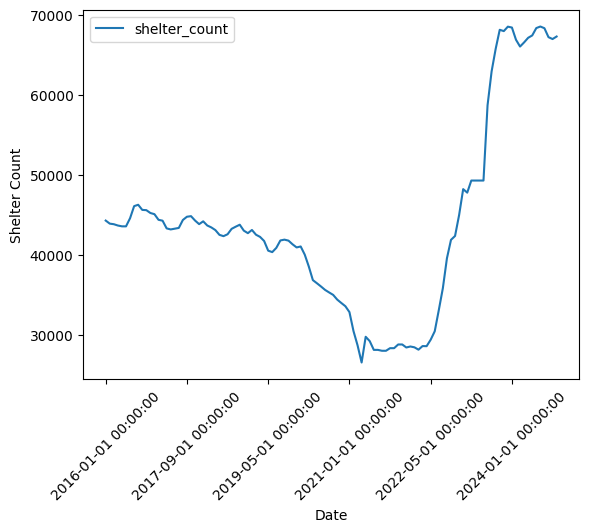

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sheltereda = fact_shelter.copy()
sheltereda = sheltereda.sort_values(by='report_date',ascending=True)
sheltereda.set_index(keys='report_date',inplace=True)
shelterline = sheltereda.plot(kind='line')
shelterline.set_ylabel('Shelter Count')
shelterline.set_xlabel("Date")
shelterline.tick_params("x",rotation=45)

# check quarterly on our timeframe, 2 year periods (a big spike after 2022)

## histogram for spread of time_of_completion (demolition specific)

In [7]:
import plotly_express as px

demo =fact_owner_demo[fact_owner_demo['job_typeid'] == 'demolition']
toc_mean = demo.groupby('month_date').agg({'time_of_completion':'mean'}).reset_index()
#very weird, a lot of demolitions are completed on 0 days (160)

# a lot of outliers in time_of_completion (can be due to a discrepency in how data was collected)
# plotting each unique time_of_demolition by building (left skewed)

unique = px.histogram(demo,x='time_of_completion')
unique.update_layout(xaxis_title='Demolition Spread')
unique.show()

# being specific to affordable and private
affordh = demo[demo['ownership_id'] == 'affordable']
affordablehist = px.histogram(affordh,'time_of_completion')
affordablehist.show()

privateh = demo[demo['ownership_id'] == 'private']
privatehist = px.histogram(privateh,'time_of_completion')
privatehist.show()

#idk if this shows too much only bc private has so many more data points (maybe we do bins)

## trajectory of demolitions over time

<Axes: xlabel='Date', ylabel='Demolition Count'>

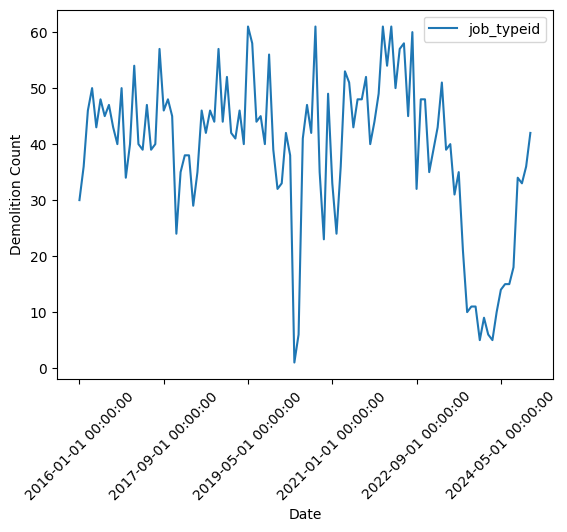

In [8]:
# SHOWS ALL DEMOLITIONS OVER TIME
demoeda = demo.copy()

demoeda = demoeda[['month_date','job_typeid']]
demoeda = demoeda.sort_values(by='month_date',ascending=True)
demoeda = demoeda.groupby('month_date').agg({'job_typeid':'count'})
#demoeda.set_index(keys='month_date',inplace=True)
demoeda = demoeda.plot(kind='line')
demoeda.set_ylabel('Demolition Count')
demoeda.set_xlabel("Date")
demoeda.tick_params("x",rotation=45)

demoeda

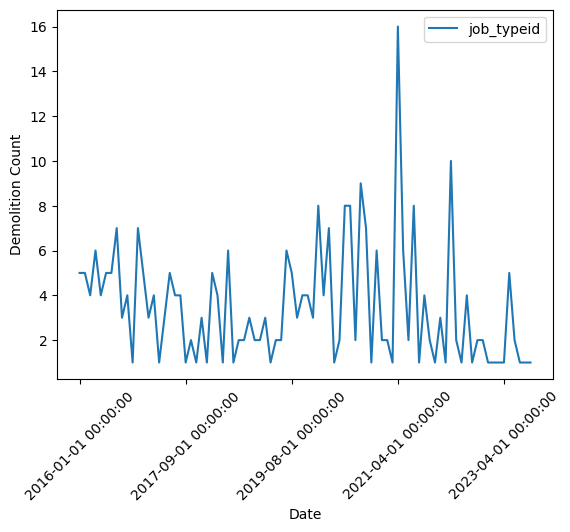

In [9]:
# SPECIFIC TO AFFORDABLE HOUSING DEMOLITIONS
demoaffordeda = demo.copy()

demoaffordeda = demoaffordeda[['month_date','job_typeid','ownership_id']]
demoaffordeda = demoaffordeda[demoaffordeda['ownership_id'] == 'affordable']
demoaffordeda = demoaffordeda.sort_values(by='month_date',ascending=True)
demoaffordeda = demoaffordeda.groupby('month_date').agg({'job_typeid':'count'})
#demoeda.set_index(keys='month_date',inplace=True)
demoaffordeda = demoaffordeda.plot(kind='line')
demoaffordeda.set_ylabel('Demolition Count')
demoaffordeda.set_xlabel("Date")
demoaffordeda.tick_params("x",rotation=45)

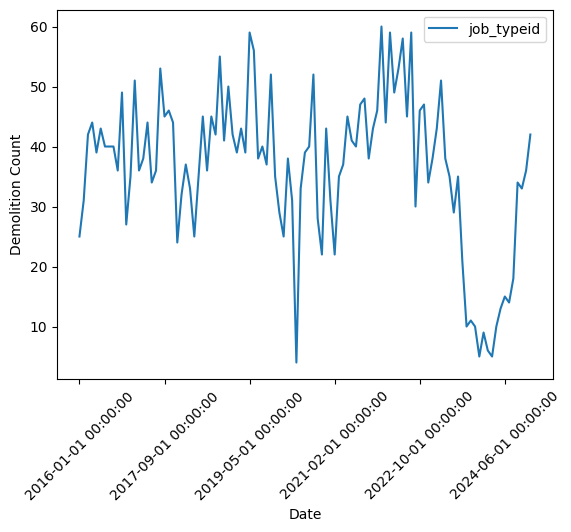

In [10]:
# SPECIFIC TO PRIVATE HOUSING DEMOLITIONS
demopriveda = demo.copy()

demopriveda = demopriveda[['month_date','job_typeid','ownership_id']]
demopriveda = demopriveda[demopriveda['ownership_id'] == 'private']
demopriveda = demopriveda.sort_values(by='month_date',ascending=True)
demopriveda = demopriveda.groupby('month_date').agg({'job_typeid':'count'})
#demoeda.set_index(keys='month_date',inplace=True)
demopriveda = demopriveda.plot(kind='line')
demopriveda.set_ylabel('Demolition Count')
demopriveda.set_xlabel("Date")
demopriveda.tick_params("x",rotation=45)

## correlation test between affordable demolitions and shelter count

In [11]:
# CORRELATION TEST FOR HOMELESSNESS AND DEMOLITIONS

# Created a filter to only show month dates between 1/1/2016 and 07/1/2023
filter_date = fact_owner_demo[(fact_owner_demo['month_date'] >='2016-01-01') &  
                              (fact_owner_demo['month_date'] <'2024-01-01')]

corr_test = filter_date.copy()

corr_test = corr_test[['month_date','job_typeid','ownership_id']]
corr_test = corr_test[(corr_test['ownership_id'] == 'affordable') & (corr_test['job_typeid'] == 'demolition')]

corr_test.sort_values(by='month_date',ascending=False)

corr_test['month_date'] = pd.to_datetime(corr_test['month_date'])

corr_test = corr_test.groupby('month_date').agg({'job_typeid':'count'})

# create an empty df to merge with original data and have all months (even ones with 0 demolitions)
empty = pd.date_range(start='2016-01-01',end='2023-06-30',freq='MS')
datedf = pd.DataFrame(data=empty)

datedf = datedf.rename(mapper={0:'month_date'},axis=1)
datedf = datedf.merge(corr_test,how='left',on='month_date')
datedf = datedf.fillna(0)

# merging with shelter data

shelter = fact_shelter.copy()

shelter['report_date'] = pd.to_datetime(shelter['report_date'])
shelter['report_date'] = shelter['report_date'].sort_values(ascending=True)

#shelter has some duplicate dates
shelter['report_date'].value_counts()

# checked if values are diff, just duplicates
duplicatedates = shelter[(shelter['report_date'] == '2021-07-01')| (shelter['report_date'] == '2021-08-01') |(shelter['report_date'] == '2021-09-01') |(shelter['report_date'] == '2021-10-01')]
duplicatedates

shelter['report_date'] = shelter['report_date'].drop_duplicates()
# renaming to be able to merge
shelter= shelter.rename(mapper={'report_date':'month_date'},axis=1)

# complete merge of dates, counts of affordable demolitions and shelter counts
datedf = datedf.merge(shelter,how='left',on='month_date')

datedf.set_index(keys='month_date')

datedf = datedf.rename(mapper={'job_typeid':'affordable_demo'},axis=1)

datedf.corr()

# correlation between affordable demolitions and shelter counts is negative


display(datedf.head(20))
display(datedf.tail(20))

display(datedf.corr())

,month_date,affordable_demo,shelter_count
0,2016-01-01,5.0,44265
1,2016-02-01,5.0,43882
2,2016-03-01,4.0,43809
3,2016-04-01,6.0,43645
4,2016-05-01,4.0,43543
5,2016-06-01,5.0,43541
6,2016-07-01,5.0,44562
7,2016-08-01,7.0,46072
8,2016-09-01,3.0,46243
9,2016-10-01,4.0,45600


,month_date,affordable_demo,shelter_count
70,2021-11-01,1.0,28382
71,2021-12-01,3.0,28507
72,2022-01-01,1.0,28403
73,2022-02-01,10.0,28108
74,2022-03-01,2.0,28559
75,2022-04-01,1.0,28546
76,2022-05-01,4.0,29355
77,2022-06-01,0.0,30412
78,2022-07-01,0.0,33060
79,2022-08-01,1.0,35811


,month_date,affordable_demo,shelter_count
month_date,1.000000,-0.14806,-0.484799
affordable_demo,-0.148060,1.00000,-0.170540
shelter_count,-0.484799,-0.17054,1.000000


We noticed a postive correlation between affordable demolitions and shelter counts. Meaning as affordable demolitions increased so did the number of people requiring shelters. 

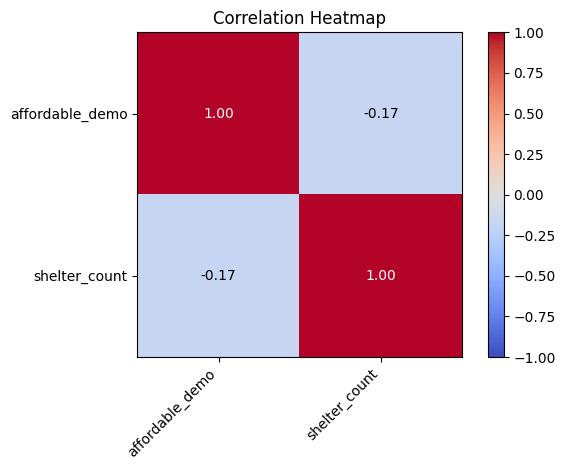

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = datedf.corr(numeric_only=True)

fig, ax = plt.subplots()

# Use a cleaner diverging colormap
cax = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Axis ticks
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))

ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.columns)

# Add correlation values inside cells
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        value = corr_matrix.iloc[i, j]
        ax.text(j, i, f"{value:.2f}",
                ha="center",
                va="center",
                color="white" if abs(value) > 0.5 else "black")

# Colorbar
fig.colorbar(cax)

ax.set_title("Correlation Heatmap")

plt.tight_layout()
plt.show()


# ANOVA TEST TO SEE DIFFERENCE BETWEEN PROPORTIONS OF BOROUGHS

### might need to adjust what this ANOVA is checking...

In [13]:
# filter for all demolitions (looking to find any trends demolition specific)
demolitions = fact_owner_demo[fact_owner_demo['job_typeid'] == 'demolition']
# able to see time of completion is quickest in staten island
demolitions.groupby('borough').agg({'time_of_completion':'mean'})

demolitions['borough'].value_counts()

# grouping fact table by jop_typeid (construction/demolition), ownership_id (affordable/private), and borough
# counting bin as it'll represent each unique building
boroughwork = fact_owner_demo.groupby(['job_typeid','ownership_id','borough']).agg({'bin':'count'}).sort_values(by=['ownership_id','borough']).reset_index()

display(boroughwork)

# filtering to total demolitions
totaldemolitions = boroughwork[boroughwork['job_typeid'] == 'demolition'].reset_index()
# creating a list for all total demolitions
listtotaldem = totaldemolitions['bin']
# creating a total buildings dataframe to have just ownership_id and borough & sum of buildings
totalbuildings = boroughwork.groupby(['ownership_id','borough']).agg({'bin':'sum'}).reset_index()

totalbuildings['totaldem'] = listtotaldem

totalbuildings['proportion'] = totalbuildings['totaldem'] / totalbuildings['bin']

totalbuildings.rename(columns={'bin':'totalbuildings'},inplace=True)

display(totalbuildings)

,job_typeid,ownership_id,borough,bin
0,construction,affordable,Bronx,90
1,demolition,affordable,Bronx,40
2,construction,affordable,Brooklyn,451
3,demolition,affordable,Brooklyn,81
4,construction,affordable,Manhattan,40
5,demolition,affordable,Manhattan,15
6,construction,affordable,Queens,96
7,demolition,affordable,Queens,98
8,construction,affordable,Staten Island,17
9,demolition,affordable,Staten Island,68


,ownership_id,borough,totalbuildings,totaldem,proportion
0,affordable,Bronx,130,40,0.307692
1,affordable,Brooklyn,532,81,0.152256
2,affordable,Manhattan,55,15,0.272727
3,affordable,Queens,194,98,0.505155
4,affordable,Staten Island,85,68,0.800000
5,private,Bronx,1575,625,0.396825
6,private,Brooklyn,4348,1136,0.261270
7,private,Manhattan,675,176,0.260741
8,private,Queens,4152,1240,0.298651
9,private,Staten Island,3618,723,0.199834


In [14]:
# takes each borough & groups by proportion
# creates a dictionary of lists (for ANOVA)
borough_lists = (
    totalbuildings
    .groupby('borough')['proportion']
    .apply(list)
    .to_dict()
)

borough_lists

{'Bronx': [0.3076923076923077, 0.3968253968253968],
 'Brooklyn': [0.15225563909774437, 0.2612695492180313],
 'Manhattan': [0.2727272727272727, 0.2607407407407407],
 'Queens': [0.5051546391752577, 0.29865125240847784],
 'Staten Island': [0.8, 0.1998341625207297]}

In [15]:
# Null Hypothesis: 
# The average proportions of demolition/total buildings for affordability and private are the same
# Alternate Hypothesis:
# At least one group's mean is different from the others.

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

manhattan = borough_lists['Manhattan']
bronx = borough_lists['Bronx']
brooklyn = borough_lists['Brooklyn']
queens = borough_lists['Queens']
stateni = borough_lists['Staten Island']

# perform one way ANOVA
f_statistic, p_value = f_oneway(manhattan, bronx, brooklyn, queens, stateni)

print('Our P-Value for our One-Way ANOVA is :',p_value)
print('This means we must reject our Alternate Hypothesis, and our Null Hypothesis is true.\n')

print("To make sure, I did a Tukey's Test:")
# create a dataframe with all values for tukey's test
data = manhattan + bronx + brooklyn + queens + stateni
labels = ['manhattan']*len(manhattan) + ['bronx']*len(bronx) + ['brooklyn']*len(brooklyn) + ['queens']*len(queens) + ['stateni']*len(stateni)

# Perform Tukey's Test
tukey_results = pairwise_tukeyhsd(endog=data, groups=labels, alpha=0.05)
print(tukey_results,"\n Our Tukey's Test confirms there are no statistically significant differences between borough proportions.")


Our P-Value for our One-Way ANOVA is : 0.6674873008601531
This means we must reject our Alternate Hypothesis, and our Null Hypothesis is true.

To make sure, I did a Tukey's Test:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
    bronx  brooklyn  -0.1455  0.946 -0.9704 0.6794  False
    bronx manhattan  -0.0855 0.9918 -0.9104 0.7393  False
    bronx    queens   0.0496  0.999 -0.7752 0.8745  False
    bronx   stateni   0.1477 0.9434 -0.6772 0.9725  False
 brooklyn manhattan     0.06 0.9979 -0.7649 0.8848  False
 brooklyn    queens   0.1951 0.8668 -0.6297   1.02  False
 brooklyn   stateni   0.2932 0.6399 -0.5317  1.118  False
manhattan    queens   0.1352 0.9578 -0.6897   0.96  False
manhattan   stateni   0.2332 0.7853 -0.5917  1.058  False
   queens   stateni    0.098 0.9864 -0.7269 0.9229  False
--------------------------------------------------------- 
 Our Tu

# TWO SAMPLE T-TEST OF PROPORTIONS VS PROPORTION (borough level)

In [16]:
# Import the necessary library
from scipy import stats

affordable = totalbuildings[totalbuildings['ownership_id'] == 'affordable']
private = totalbuildings[totalbuildings['ownership_id'] == 'private']

# Perform the independent t-test (Welch's t-test)
# We use equal_var=False because we assume the group variances might not be equal
result = stats.ttest_ind(private['proportion'], affordable['proportion'], equal_var=False, alternative='greater')

# Print the results
print(f"t-statistic: {result.statistic:.2f}")
print(f"p-value: {result.pvalue:.4f}")

# Make a decision based on a common significance level (e.g., alpha = 0.05)
alpha = 0.05
if result.pvalue < alpha:
   print("\nConclusion: The proportion of borough level demolitions of private housing to total private housing is greater than borough level proportions\n of demolished affordable housing to total affordable housing")
else:
   print("\nConclusion: The proportion of borough level demolitions of private housing to total private housing is not greater than borough level proportions\n of demolished affordable housing to total affordable housing")

display(affordable)
display(private)

t-statistic: -1.05
p-value: 0.8280

Conclusion: The proportion of borough level demolitions of private housing to total private housing is not greater than borough level proportions
 of demolished affordable housing to total affordable housing


,ownership_id,borough,totalbuildings,totaldem,proportion
0,affordable,Bronx,130,40,0.307692
1,affordable,Brooklyn,532,81,0.152256
2,affordable,Manhattan,55,15,0.272727
3,affordable,Queens,194,98,0.505155
4,affordable,Staten Island,85,68,0.800000


,ownership_id,borough,totalbuildings,totaldem,proportion
5,private,Bronx,1575,625,0.396825
6,private,Brooklyn,4348,1136,0.261270
7,private,Manhattan,675,176,0.260741
8,private,Queens,4152,1240,0.298651
9,private,Staten Island,3618,723,0.199834


In [17]:
# changing sampling to be every 6 months, allows for grouping of months since demolitions don't happen frequently

attempt = datedf.set_index('month_date')

attempt['affordable_demo'] = attempt['affordable_demo'].astype(int)

attempt = attempt.resample('QS').sum()


attempt.corr()

,affordable_demo,shelter_count
affordable_demo,1.000000,-0.235768
shelter_count,-0.235768,1.000000


In [23]:
fact_owner_demo.groupby(['month_date','job_typeid']).agg({'job_typeid':'count'})

job_typeid
month_date          job_typeid              
2016-01-01 00:00:00 construction         108
                    demolition            30
2016-02-01 00:00:00 construction         138
                    demolition            36
2016-03-01 00:00:00 construction         180
...                                      ...
2024-10-01 00:00:00 demolition            33
2024-11-01 00:00:00 construction          61
                    demolition            36
2024-12-01 00:00:00 construction          83
                    demolition            42

[216 rows x 1 columns]

,month_date,bin,job_typeid,ownership_id,borough,date_filed,date_completed,time_of_completion
0,2016-06-01 00:00:00,2124541,construction,private,Bronx,2014-03-17 00:00:00,2016-06-23 00:00:00,829
1,2016-08-01 00:00:00,2129579,construction,private,Bronx,2014-03-17 00:00:00,2016-08-17 00:00:00,884
2,2019-05-01 00:00:00,2129389,construction,private,Bronx,2014-02-27 00:00:00,2019-05-01 00:00:00,1889
3,2019-10-01 00:00:00,2129388,construction,private,Bronx,2014-02-27 00:00:00,2019-10-24 00:00:00,2065
4,2016-11-01 00:00:00,2126049,construction,private,Bronx,2014-02-24 00:00:00,2016-11-18 00:00:00,998
...,...,...,...,...,...,...,...,...
15359,2019-07-01 00:00:00,2129091,construction,private,Bronx,2013-01-25 00:00:00,2019-07-22 00:00:00,2369
15360,2016-04-01 00:00:00,2124492,construction,private,Bronx,2013-09-26 00:00:00,2016-04-29 00:00:00,946
15361,2018-01-01 00:00:00,2128994,construction,private,Bronx,2013-08-02 00:00:00,2018-01-23 00:00:00,1635
15362,2018-01-01 00:00:00,2124392,construction,private,Bronx,2013-08-02 00:00:00,2018-01-23 00:00:00,1635


# feature engineering 'sub' column

In [ ]:

affordabledata = fact_owner_demo[fact_owner_demo['ownership_id'] == 'affordable']

affordabledata['month_date'] = pd.to_datetime(affordabledata['month_date'])

affordabledata = affordabledata.groupby(['month_date','job_typeid']).agg({'bin':'count'}).reset_index()

affordabledataconst = affordabledata[affordabledata['job_typeid'] == 'construction']


affordabledataconst

affordabledataconst.rename({'bin':'construction'},axis=1,inplace=True)
affordabledataconst = affordabledataconst.drop('job_typeid',axis=1)

affordabledatademo = affordabledata[affordabledata['job_typeid'] == 'demolition']


affordabledatademo.rename({'bin':'demolition'},axis=1,inplace=True)
affordabledatademo = affordabledatademo.drop('job_typeid',axis=1)


affdemocount = affordabledataconst.merge(affordabledatademo,how='left',on='month_date')

affdemocount['demolition'] = affdemocount['demolition'].fillna(0)


affdemocount['sub'] = affdemocount['construction'] - affdemocount['demolition']

print(affdemocount['construction'].sum())
print(affdemocount['demolition'].sum())
affdemocount['month_date'] =pd.to_datetime(affdemocount['month_date'])



affdcs = shelter.merge(affdemocount,how='left',on='month_date')

affdcs.fillna(0,inplace=True)

affdcs.set_index(keys='month_date',inplace=True)

affdcs.corr()


694
295.0


/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_90222/2064382541.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_90222/2064382541.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_90222/2064382541.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

,shelter_count,construction,demolition,sub
shelter_count,1.000000,-0.090085,-0.379291,0.065073
construction,-0.090085,1.000000,0.139572,0.917047
demolition,-0.379291,0.139572,1.000000,-0.266882
sub,0.065073,0.917047,-0.266882,1.000000
